In [70]:

import nomic
import json

#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm
from graspologic.embed import ClassicalMDS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz



In [76]:
df_vote_result=pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Twitters/congressional-twin/data/data/115-2017_s179.csv')
df_vote_result.drop('district', axis=1, inplace=True)
df_vote_result.dropna(inplace=True)
vote_str = '115-2017_s179'
df_vote_result.head()

,Unnamed: 0,person,state,vote,name,party,matched-name,twitter-handle,average-embd-global,average-embd-issue-specific,matched-state,matched-party
0,0,300002,TN,Yea,"Sen. Lamar Alexander [R, 2003-2020]",Republican,Lamar Alexander R-TN,senalexander,"[0.009264346055505097, 0.04242450703633876, -0...","[0.009686428719124366, 0.0467718743829986, -0....",TN,R
3,3,300023,MS,Yea,"Sen. Thad Cochran [R, 1979-2018]",Republican,Thad Cochran R-MS,senthadcochran,"[0.01546081527114829, 0.030818887950514285, -0...","[0.017809977192850508, 0.050288344276021926, -...",MS,R
7,7,300038,IL,Nay,"Sen. Richard Durbin [D, 1997-2026]",Democrat,Dick Durbin D-IL,senatordurbin,"[0.009737420634648096, 0.04754690504386066, -0...","[0.013919488992542028, 0.04474114230833948, -0...",IL,D
8,8,300041,WY,Yea,"Sen. Michael Enzi [R, 1997-2020]",Republican,Mike Enzi R-WY,senatorenzi,"[0.013146516921950431, 0.05199884669776711, -0...","[0.015217657564050061, 0.0516270156634056, -0....",WY,R
9,9,300043,CA,Nay,"Sen. Dianne Feinstein [D, 1992-2023]",Democrat,Dianne Feinstein D-CA,senfeinstein,"[0.020933950016889493, 0.04852057007405176, -0...","[0.022574508228985418, 0.0440640030155741, -0....",CA,D


In [77]:
average_embd_global = np.array([eval(d) for d in df_vote_result['average-embd-global'].values])
average_embd_issue_specific = np.array([eval(d) for d in df_vote_result['average-embd-issue-specific'].values])

vote = [v for v in df_vote_result['vote'].values]
party = [p for p in df_vote_result['matched-party'].values]

vote_inds = []
y = []
for i, v in enumerate(vote):
    if v.lower() == 'nay':
        y.append(0)
    elif v.lower() == 'yea':
        y.append(1)
    else:
        continue
    vote_inds.append(i)    
vote_inds = np.array(vote_inds) ## exclude the not voting 


Text(0.5, 1.0, 'CMDS global // by vote')

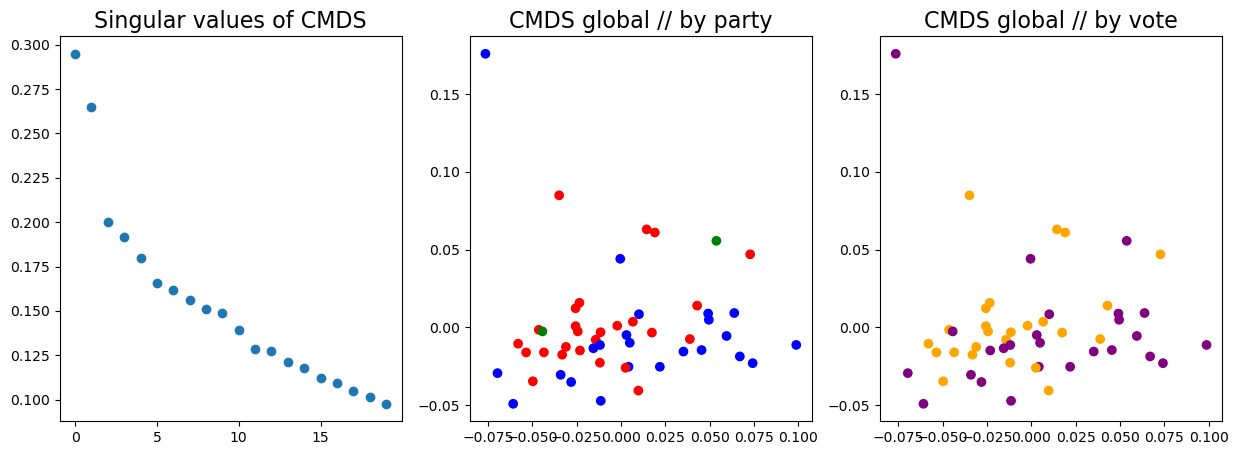

In [78]:
## visual analysis

cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd_global)
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd_global)

vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'black'
}

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title('Singular values of CMDS', fontsize=16)
ax[1].set_title('CMDS global // by party', fontsize=16)
ax[2].set_title('CMDS global // by vote', fontsize=16)

Text(0.5, 1.0, 'CMDS issue specific // by vote')

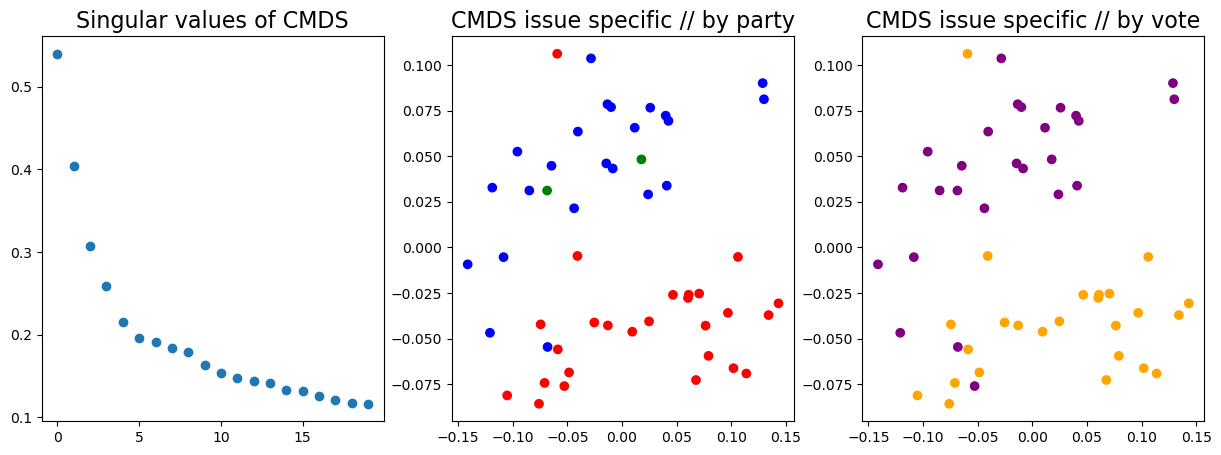

In [80]:
cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd_issue_specific)
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd_issue_specific)

vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'black'
}

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title('Singular values of CMDS', fontsize=16)
ax[1].set_title('CMDS issue specific // by party', fontsize=16)
ax[2].set_title('CMDS issue specific // by vote', fontsize=16)

In [28]:
cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd_global)

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas
import matplotlib.pyplot as plt
import seaborn as sns

### 2D CMDS for predicting votes: issue_specific  average.e is much better than  global average 

In [85]:
cmds_embds = cmds.fit_transform(average_embd_global)
x = cmds_embds[vote_inds,:2]
vote_model = LogisticRegression()
vote_model.fit(x, y)
er = bas(y, vote_model.predict(x))
er


0.5

In [86]:
cmds_embds = cmds.fit_transform(average_embd_issue_specific)
x = cmds_embds[vote_inds,:2]
vote_model = LogisticRegression()
vote_model.fit(x, y)
er = bas(y, vote_model.predict(x))
er

0.7807692307692308

## 1D cmds for predicting vote, still issue_specifc is better than global

Text(0.5, 1.02, 'Efficacy of average embedding+LogR \n for 115-2017_s179')

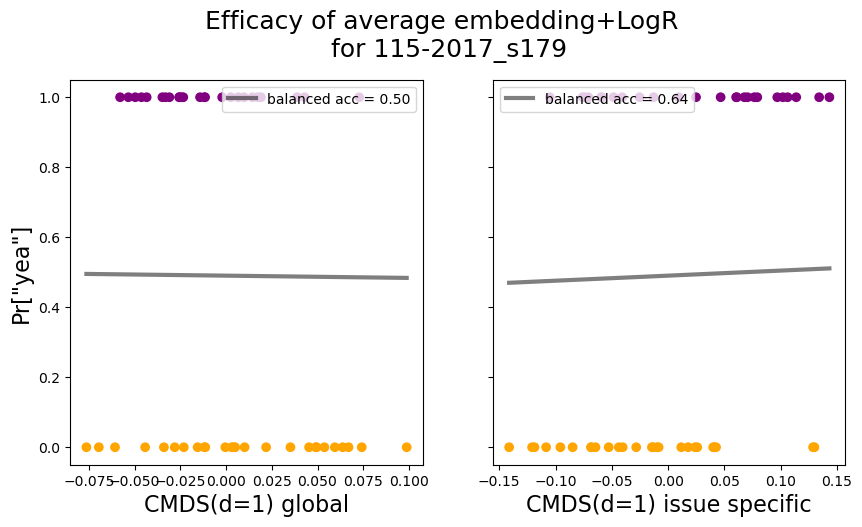

In [111]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

### global
cmds_embds = cmds.fit_transform(average_embd_global)
x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1) global', fontsize=16)



###isuue specific
cmds_embds = cmds.fit_transform(average_embd_issue_specific)
x = cmds_embds[vote_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[1].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel('CMDS(d=1) issue specific', fontsize=16)


fig.suptitle(f'Efficacy of average embedding+LogR \n for {vote_str}', fontsize=18, y=1.02)



## LDA $\circ$ CMDS(d=20) with party label for predicting votes

Text(0.5, 0, 'Issue speicifc LDA(y=party) o CMDS(d=4)')

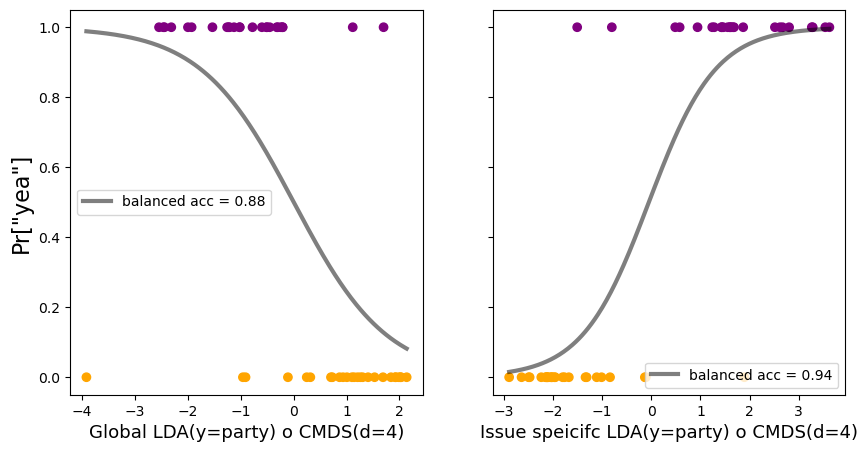

In [121]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds = ClassicalMDS(n_components=4)
cmds_embds = cmds.fit_transform(average_embd_global)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])[:,:1]

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[0].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel(f'Global LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=13)


cmds = ClassicalMDS(n_components=4)
cmds_embds = cmds.fit_transform(average_embd_issue_specific)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])[:,:1]

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'Issue speicifc LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=13)




In [35]:




lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])

party_model = LogisticRegression()
party_model.fit(x, y)



xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LogR \n for {vote_str}', fontsize=18, y=1.02)


LogisticRegression()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

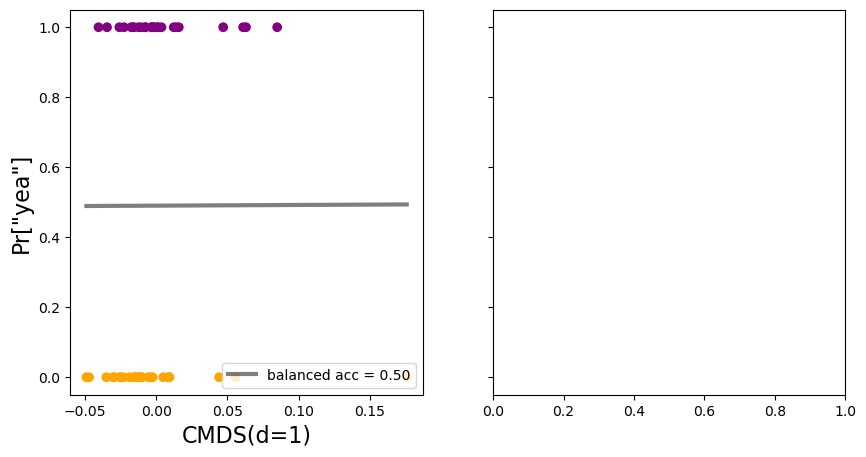

In [61]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds_embds = cmds.fit_transform(average_embd_global)


x = cmds_embds[vote_inds,1:2]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1)', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=vote) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LogR with issue_specifc\n for {vote_str}', fontsize=18, y=1.02)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

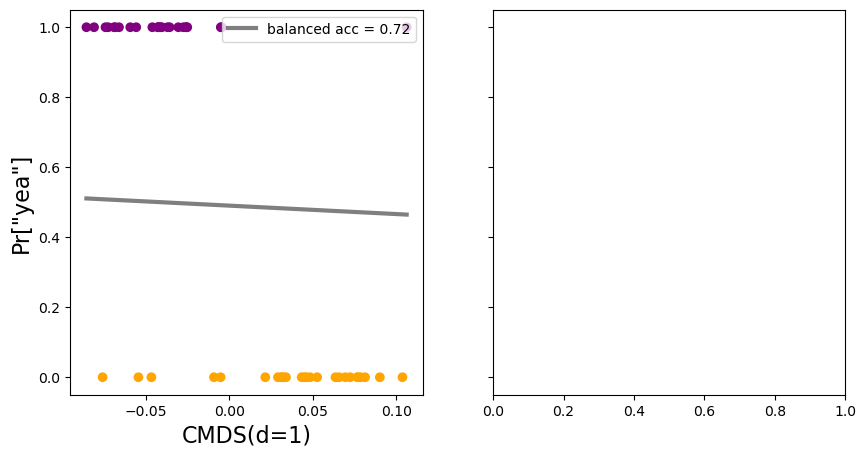

In [94]:

fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds_embds = cmds.fit_transform(average_embd_issue_specific)


x = cmds_embds[vote_inds,1:2]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1)', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=vote) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LogR with issue_specifc\n for {vote_str}', fontsize=18, y=1.02)

In [43]:
cmds_embds = cmds.fit_transform(average_embd_issue_specific)
cmds.singular_values_

array([1.93668805, 1.63645919, 1.30901512, 1.00856943, 0.92261489,
       0.82405469, 0.79316456, 0.76237597, 0.73661586, 0.72664483,
       0.69822798, 0.67521876, 0.63772731, 0.61995383, 0.60907847,
       0.59633691, 0.57450145, 0.54243119, 0.52329009, 0.50589183])

Text(0.5, 1.02, 'Efficacy of representation+LogR with issue_specific \n for 115-2017_s179')

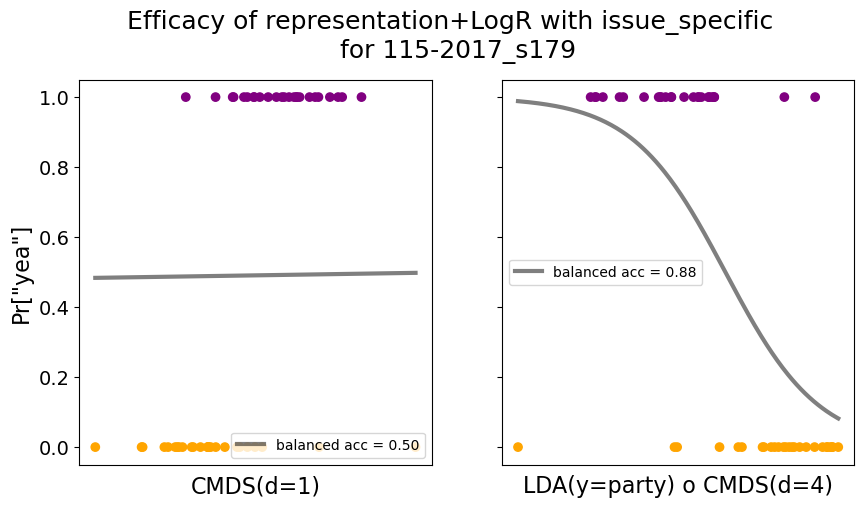

In [98]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

cmds_embds = cmds.fit_transform(average_embd_global)

x = cmds_embds[vote_inds,2:3]

vote_model = LogisticRegression()
vote_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y])
ax[0].scatter(x, y, c=color_list)

# Plot the logistic regression curve
er = bas(y, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].legend()
ax[0].set_xlabel('CMDS(d=1)', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[vote_inds], np.array(party)[vote_inds])
x = lda.transform(cmds_embds[vote_inds])[:,:1]

party_model = LogisticRegression()
party_model.fit(x, y)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y, c=color_list)

er = bas(y, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].legend()
ax[1].set_xlabel(f'LDA(y=party) o CMDS(d={cmds_embds.shape[1]})', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)

fig.suptitle(f'Efficacy of representation+LogR with issue_specific \n for {vote_str}', fontsize=18, y=1.02)

In [132]:
from sklearn.manifold import Isomap

# Create an instance of Isomap with n_components=1
#isomap = Isomap(n_components=200)

# Fit and transform the average_embd_issue_specific array
#x = isomap.fit_transform(average_embd_global)[vote_inds,:] 
#x = isomap.fit_transform(average_embd_issue_specific)[vote_inds,:]  

cmds_embds = cmds.fit_transform(average_embd_issue_specific)

x = cmds_embds[vote_inds,:300]


vote_model = LogisticRegression()
vote_model.fit(x, y)

bas(y, vote_model.predict(x))


0.5

In [65]:
x = average_embd_issue_specific[vote_inds,:]

vote_model = LogisticRegression()
vote_model.fit(x, y)

#er = bas(y, vote_model.predict(x))
accuracy_score(y, vote_model.predict(x))
vote_model.predict_proba(x)

array([[0.26016137, 0.73983863],
       [0.25928695, 0.74071305],
       [0.25138659, 0.74861341],
       [0.28096316, 0.71903684],
       [0.21501954, 0.78498046],
       [0.27265037, 0.72734963],
       [0.24718208, 0.75281792],
       [0.20261708, 0.79738292],
       [0.2128165 , 0.7871835 ],
       [0.24480229, 0.75519771],
       [0.23151611, 0.76848389],
       [0.2062293 , 0.7937707 ],
       [0.34290333, 0.65709667],
       [0.21154668, 0.78845332],
       [0.32248206, 0.67751794],
       [0.22959653, 0.77040347],
       [0.209828  , 0.790172  ],
       [0.2221744 , 0.7778256 ],
       [0.20132694, 0.79867306],
       [0.21296118, 0.78703882],
       [0.27378224, 0.72621776],
       [0.21652962, 0.78347038],
       [0.19612421, 0.80387579],
       [0.2276512 , 0.7723488 ],
       [0.22591223, 0.77408777],
       [0.20624075, 0.79375925],
       [0.21322132, 0.78677868],
       [0.20306722, 0.79693278],
       [0.21051655, 0.78948345],
       [0.22906405, 0.77093595],
       [0.